In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
import pickle
import random
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

In [2]:
data_dir = '../data'

vid_dirs = [
    './data/animations_all/HH/Style1/7',
    './data/animations_all/HH/Style1/10',
    './data/animations_all/HH/Style1/20',
    './data/animations_all/HH/Style1/50',
    './data/animations_all/HH/Style1/100',
    './data/animations_all/HH/Style2/7',
    './data/animations_all/HH/Style2/10',
    './data/animations_all/HH/Style2/20',
    './data/animations_all/HH/Style2/50',
    './data/animations_all/HH/Style2/100',
    './data/animations_all/HO/Style1',
    './data/animations_all/HO/Style2',
    './data/animations_all/HO/Style3',
    './data/animations_all/OO/collision',
    './data/animations_all/OO/rod',
    './data/animations_all/OO/rope',
    './data/animations_all/OO/spring',
]

general_types = [
0,
1,
2,
3,
4,
0,
1,
2,
3,
4,
5,
5,
5,
6,
7,
8,
9
]
markers = {0: 'o', 1: 'o', 2: 'o', 3: 'o', 4: 'o',
           5: '^', 6: 's', 7: 's', 8: 's', 9: 's'}

In [3]:
"""load human responses"""
response_file_name = data_dir + '/human_responses_exp1.txt'
HH, OO, HO = [], [], []
with open(response_file_name) as f:
    for line in f:
        res = [float(x) for x in line.split()]
        HH.append(res[0] / sum(res[:3]))
        OO.append(res[1] / sum(res[:3]))
        HO.append(res[2] / sum(res[:3]))

In [8]:
"""load and preprocess model results"""
max_loss = 0.5
D1, D2, D_all = [], [], [] # deviations of each entity + average of both entities
L1, L2, L_all = [], [], [] # log-likelihood ratios of each entity + average of both entities
dataset = 50
ll_ratios = pickle.load(open(data_dir + '/BaselineDNN_L_50.pik', 'rb'))
loss_all = [pickle.load(open(data_dir + '/BaselineDNN_D_{}_50.pik'.format(dataset), 'rb'))
            for dataset in ['collision', 'spring']]
for vid_dir in vid_dirs:
    losses = [loss[vid_dir] for loss in loss_all]
    for i, vid_id in enumerate(range(1, 100, 2)):
        L1_1 = ll_ratios[vid_dir][0][i]
        L1_2 = ll_ratios[vid_dir][1][i]
        L2_1 = ll_ratios[vid_dir][2][i]
        L2_2 = ll_ratios[vid_dir][3][i]
        
        # select the best goal combinations
        best = -1e6
        if L1_1 + L2_1 > best:
            best = L1_1 + L2_1
            L1_mean, L2_mean = L1_1, L2_1
        if L1_1 + L2_2 > best:
            best = L1_1 + L2_2
            L1_mean, L2_mean = L1_1, L2_2
        if L1_2 + L2_1 > best:
            best = L1_2 + L2_1
            L1_mean, L2_mean = L1_2, L2_1
        if L1_2 + L2_2 > best:
            best = L1_2 + L2_2
            L1_mean, L2_mean = L1_2, L2_2
        L_all.append((L1_mean + L2_mean) * 0.5)
        L1.append(L1_mean)
        L2.append(L2_mean)
       
        # select the best physical configurations
        loss_1, loss_2 = 1e8, 1e8
        min_loss = 1e8
        for D in losses:
            cur_loss = np.array(D[i][0][0:]).clip(0,max_loss).mean() + np.array(D[i][1][0:]).clip(0,max_loss).mean()
            if cur_loss < min_loss:
                min_loss = cur_loss
                loss_1, loss_2 = np.array(D[i][0][0:]).clip(0,max_loss), np.array(D[i][1][0:]).clip(0,max_loss)
        D_all.append(0.5 * ((loss_1.mean() + loss_2.mean())))
        D1.append(loss_1.mean())
        D2.append(loss_2.mean())

#         print(vid_id, L1_mean, L2_mean, D1[-1], D2[-1])
#         print(vid_id, max(L1_1, L1_2), max(L2_1, L2_2))

In [9]:
def get_viz_datapoints(num_videos_per_type, N, exclude_types=[]):
    """get data points for visualization"""
    Ds, Ls = [], []
    HHs, HOs, OOs, colors = [], [], [], []
    types = []
    start = 0
    for vid_type, vid_dir in enumerate(vid_dirs):
        if general_types[vid_type] not in exclude_types:
            types += [general_types[vid_type]] * (50 // N)
            for i in range(0, num_videos_per_type // N):
                Ds.append(sum(D_all[start + i * N : start + (i + 1) * N]) / N)
                Ls.append(sum(L_all[start + i * N : start + (i + 1) * N]) / N)
                cur_OO = sum(OO[start + i * N : start + (i + 1) * N]) / N
                cur_HO = sum(HO[start + i * N : start + (i + 1) * N]) / N
                cur_HH = sum(HH[start + i * N : start + (i + 1) * N]) / N
                OOs.append(cur_OO)
                HOs.append(cur_HO)
                HHs.append(cur_HH)
                colors.append((cur_HH, cur_HO, cur_OO))
        start += num_videos_per_type
    return Ds, Ls, HHs, HOs, OOs, colors, types

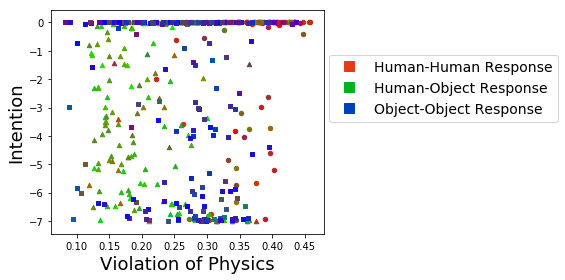

In [10]:
"""Visualizing individual stimuli (100% HH + HO + OO)"""
num_videos_per_type = 50
N = 1
Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(num_videos_per_type, N, exclude_types=[0,1,2,3])
ms = [markers[type_id] for type_id in types]

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, frameon=True)
ax.set_xlabel('Violation of Physics', fontsize=18)
ax.set_ylabel('Intention', fontsize=18)
s = 20
for D, L, c, m in zip(Ds, Ls, colors, ms):
    plt.scatter(x=D, y=L,
                c=np.array(c).reshape(1,-1), s=s, marker=m)

legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                      markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                  Line2D([0], [0], marker='s', color='w', label='HO',
                      markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                  Line2D([0], [0], marker='s', color='w', label='OO',
                      markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
          bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

fig.tight_layout()

# fig.savefig('space_individual_baseline_full.pdf')

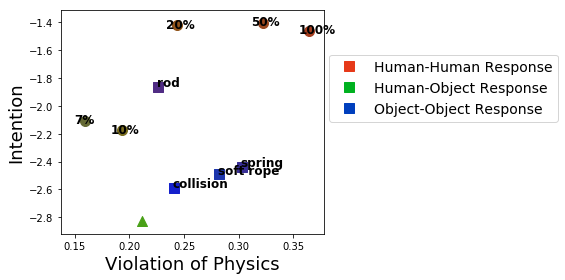

In [11]:
"""Visualizing centers (all HH + HO + OO)"""
num_videos_per_type = 50
N = 50
Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(num_videos_per_type, N)

# get centers
Ds0 = list(Ds)
Ls0 = list(Ls)
colors0 = list(colors)
Ds, Ls, colors = [], [], []
ms = []
for type_id in range(10):
    tmp_D = [D for D, type in zip(Ds0, types) if type == type_id]
    tmp_L = [L for L, type in zip(Ls0, types) if type == type_id]
    tmp_colors = [c for c, type in zip(colors0, types) if type == type_id]
    Ds.append(np.array(tmp_D).mean())
    Ls.append(np.array(tmp_L).mean())
    mean_c = (np.array([c[0] for c in tmp_colors]).mean(), 
              np.array([c[1] for c in tmp_colors]).mean(), 
              np.array([c[2] for c in tmp_colors]).mean())
    colors.append(mean_c)
    ms.append(markers[type_id])

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, frameon=True) 
ax.set_xlabel('Violation of Physics', fontsize=18)
ax.set_ylabel('Intention', fontsize=18)
s = 100
for D, L, c, m in zip(Ds, Ls, colors, ms):
    plt.scatter(x=D, y=L,
                c=np.array(c).reshape(1,-1), s=s, marker=m)

legend_elements = [Line2D([0], [0], marker='s', color='w', label='HH',
                      markerfacecolor=(0.900, 0.2250, 0.0980), markeredgecolor=(0.900, 0.2250, 0.0980), markersize=10),
                  Line2D([0], [0], marker='s', color='w', label='HO',
                      markerfacecolor=(0, 0.6940, 0.1250), markeredgecolor=(0, 0.6940, 0.1250), markersize=10),
                  Line2D([0], [0], marker='s', color='w', label='OO',
                      markerfacecolor=(0, 0.2470, 0.7410), markeredgecolor=(0, 0.2470, 0.7410), markersize=10)]    
ax.legend(legend_elements, ['Human-Human Response', 'Human-Object Response', 'Object-Object Response'], 
          bbox_to_anchor=(1.02, 0.5), loc=3, borderaxespad=0., fontsize=14)

str_list = ['7%', '10%', '20%', '50%', '100%', '', 'collision', 'rod', 'soft rope', 'spring']
for id, (x, y, s) in enumerate(zip(Ds, Ls, str_list)):
    dx, dy = 0, 0
#     if id == 6:
#         dx, dy = -0.01, -0.035
#     if id == 8:
#         dx, dy = 0, +0.005
#     if id == 9:
#         dx, dy = 0.015, -0.01
    if id < 6:
        plt.text(x=x - 0.01, y=y - 0.02, 
                 s=s, fontsize=12, fontweight='bold')
    else:
        plt.text(x=x - 0.001 + dx, y=y + 0.001 + dy, 
                 s=s, fontsize=12, fontweight='bold')
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

fig.tight_layout()

# fig.savefig('space_centers_baseline_full.pdf')

In [31]:
"""model predictions based on freq"""
from sklearn.linear_model import LogisticRegression

freq_entity_1 = {
    0: 7,
    1: 10,
    2: 20,
    3: 50,
    4: 100,
    5: 100,
    6: 0,
    7: 0,
    8: 0,
    9: 0
}

freq_entity_2 = {
    0: 7,
    1: 10,
    2: 20,
    3: 50,
    4: 100,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0
}
gt_class = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 1,
    6: 2,
    7: 2,
    8: 2,
    9: 2
}


num_videos_per_type = 50
N = 1
Ds, Ls, HHs, HOs, OOs, colors, types = get_viz_datapoints(num_videos_per_type, N, exclude_types=[0,1,2,3])

# 2-fold cross-validation
random.seed(1)
num_rounds = 100
corr_list = [None] * num_rounds
for round_id in range(num_rounds):
    indices = list(range(len(Ds)))
    random.shuffle(indices)
    train_indices = indices[::2]
    test_indices = indices[1::2]
    
    X_train = np.array([[freq_entity_1[types[i]]] for i in train_indices])
    X_test = np.array([[freq_entity_1[types[i]]] for i in test_indices])
    Y_train = np.array([[freq_entity_2[types[i]]] for i in train_indices])
    Y_test = np.array([[freq_entity_2[types[i]]] for i in test_indices])
    feat_train = np.concatenate([X_train, Y_train], axis=-1)
    feat_test = np.concatenate([X_test, Y_test], axis=-1)
    
    gt_train = np.array([gt_class[types[i]] for i in train_indices])
    
    model = LogisticRegression(random_state=0).fit(feat_train, gt_train)
    
#     types_train, types_test = [types[i] for i in train_indices], [types[i] for i in test_indices]
    data_HH_train = np.array([HHs[i] for i in train_indices])
    data_HH_test = np.array([HHs[i] for i in test_indices])
    data_HO_train = np.array([HOs[i] for i in train_indices])
    data_HO_test = np.array([HOs[i] for i in test_indices])
    data_OO_train = np.array([OOs[i] for i in train_indices])
    data_OO_test = np.array([OOs[i] for i in test_indices])
    data_GT_all = np.vstack([data_HH_test, data_HO_test, data_OO_test]).transpose().reshape(-1)
    
    pred = model.predict_proba(feat_test)
    p_pred_all = pred.transpose().reshape(-1)
    corr_list[round_id] = pearsonr(data_GT_all, p_pred_all)[0]

print('mean correlation: {}, standard dev.: {}'.format(np.round(np.array(corr_list).mean(), decimals=3), 
                                                       np.round(np.array(corr_list).std(),  decimals=3)))
    

/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/stm/anaconda3/envs/p

mean correlation: 0.002, standard dev.: 0.036


/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stm/anaconda3/envs/py35_0219/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


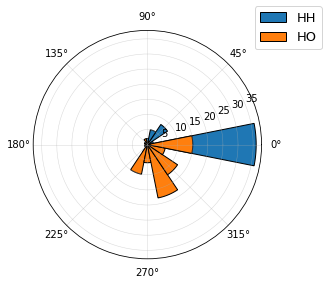

In [113]:
"""histogram of orientations of segments in Experiment 2"""
indices = []
with open(data_dir + '/indices_exp2.txt') as f:
    for line in f:
        res = [int(x) for x in line.split()]
        indices.append(res[0])
                
Hs, Os = [], []
with open(data_dir + '/human_responses_exp2.txt') as f:
    for line in f:
        res = [int(x) for x in line.split()]
        Hs.append(res[1] / sum(res))
        Os.append(res[0] / sum(res))    

D1_exp2 = [D1[i] for i in indices]
L1_exp2 = [L1[i] for i in indices]
D2_exp2 = [D2[i] for i in indices]
L2_exp2 = [L2[i] for i in indices]
colors1 = [(H, 0, O) for H, O in zip(Hs, Os)] # colors for human entities
colors2 = [(O, 0, H) for H, O in zip(Hs, Os)] # colors for object entities

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, frameon=True, polar=True) 

Dmean = np.mean(np.array(D1_exp2 + D2_exp2))
Dstd = np.std(np.array(D1_exp2 + D2_exp2))
Lmean = np.mean(np.array(L1_exp2 + L2_exp2))
Lstd = np.std(np.array(L1_exp2 + L2_exp2))
# print(Dmean, Dstd, Lmean, Lstd)

D1_exp2 = [(D - Dmean) / Dstd  for D in D1_exp2]
L1_exp2 = [(L - Lmean) / Lstd for L in L1_exp2]
D2_exp2 = [(D - Dmean) / Dstd  for D in D2_exp2]
L2_exp2 = [(L - Lmean) / Lstd for L in L2_exp2]

sig_thresh = 0.36

theta_HH_sig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
         for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[:80], D2_exp2[:80], L1_exp2[:80], L2_exp2[:80], colors1[:80], colors2[:80]) if abs(c1[0] - c2[0]) >= sig_thresh]
theta_HH_nonsig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
         for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[:80], D2_exp2[:80], L1_exp2[:80], L2_exp2[:80], colors1[:80], colors2[:80]) if abs(c1[0] - c2[0]) < sig_thresh]
theta_HO_sig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
         for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[80:], D2_exp2[80:], L1_exp2[80:], L2_exp2[80:], colors1[80:], colors2[80:]) if abs(c1[0] - c2[0]) >= sig_thresh]
theta_HO_nonsig = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
         for d1, d2, l1, l2, c1, c2 in zip(D1_exp2[80:], D2_exp2[80:], L1_exp2[80:], L2_exp2[80:], colors1[80:], colors2[80:]) if abs(c1[0] - c2[0]) < sig_thresh]
# print(len(theta_HH_sig), len(theta_HO_sig))

num_bins = 16
min_x, max_x = -math.pi, math.pi
width = 2 * math.pi / num_bins
bins = [-math.pi + width / 2 + i * width for i in range(num_bins)]
# bins = num_bins

# bars = ax.hist(theta_HH_sig + theta_HH_nonsig + theta_HO_sig + theta_HO_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HH_sig + theta_HO_sig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')

bars = ax.hist(theta_HH_sig + theta_HH_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
bars = ax.hist(theta_HO_sig + theta_HO_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
fig.legend(['HH', 'HO'], fontsize=13)

# bars = ax.hist(theta_HH_sig + theta_HH_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HO_sig + theta_HO_nonsig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HH_sig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HO_sig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# fig.legend(['HH', 'HO', 'HH (sig)', 'HO (sig)'])

# bars = ax.hist(theta_HH_sig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HO_sig, density=False, alpha = 1, bins=bins, range=(min_x, max_x), edgecolor='black')
# fig.legend(['HH (sig)', 'HO (sig)'], fontsize=13)

# bars = ax.hist(theta_HH_sig, density=False, alpha = 0.5, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HH_nonsig, density=False, alpha = 0.5, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HO_sig, density=False, alpha = 0.5, bins=bins, range=(min_x, max_x), edgecolor='black')
# bars = ax.hist(theta_HO_nonsig, density=False, alpha = 0.5, bins=bins, range=(min_x, max_x), edgecolor='black')

# bars = ax.hist(theta_HO_nonsig, density=False, alpha = 0.5, bins=bins, range=(min_x, max_x))


# fig.legend(['HH (sig)', 'HH (non-sig)', 'HO (sig)', 'HO (non-sig)'])

plt.grid(linewidth=0.5, alpha=0.5)
fig.tight_layout()
fig.savefig('theta_hist_baseline_full.pdf')


128


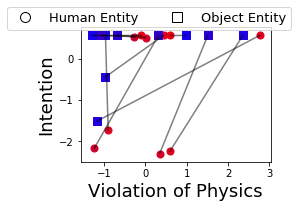

In [114]:
"""visualize representative segments"""

theta = [math.atan2(l1 - l2, d1 - d2) if c1[0] > c2[0] else math.atan2(l2 - l1, d2 - d1)
         for d1, d2, l1, l2, c1, c2 in zip(D1, D2, L1, L2, colors1, colors2) if c1[0] != c2[0]]

fig = plt.figure(figsize=(4.3, 4))
ax = fig.add_subplot(111, frameon=True) 
ax.set_xlabel('Violation of Physics', fontsize=18)
ax.set_ylabel('Intention', fontsize=18)
# visualize videos with the most consistent role judgment (top 5 from HH and HO respectively)
K = 5
cnt = 0
for start_id, end_id in zip([0, 80], [80, 160]):
    ratio = [max(c1[0], c2[0]) for c1, c2 in zip(colors1[start_id:end_id], colors2[start_id:end_id])]
    ranked_indices = list(np.argsort(ratio)[::-1])
    for vid_id, (d1, l1, d2, l2, c1, c2) in enumerate(zip(D1_exp2, L1_exp2, D2_exp2, L2_exp2, colors1, colors2)):
        if c1[0] > c2[0] and l1 < l2 - 0.2 or c1[0] < c2[0] and l1 > l2 + 0.2:
#             print(id // 50 + 1, id % 50 * 2 + 1, ':', u1, v1, u2, v2, c1[0])
            cnt += 1
        if vid_id - start_id in ranked_indices[:K]:
            plt.plot([d1, d2], [l1, l2], c='black', alpha=0.5)
            plt.scatter(x=d1, y=l1,
                        c=np.array(c1).reshape(1,-1), s=50, marker='o' if c1[0] > c2[0] else 's')
            plt.scatter(x=d2, y=l2,
                        c=np.array(c2).reshape(1,-1), s=50, marker='s' if c1[0] > c2[0] else 'o')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Entity with higher H response',
                          markerfacecolor='w', markeredgecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Entity with higher O response',
                          markerfacecolor='w', markeredgecolor='k', markersize=10)]
ax.legend(legend_elements, ['Human Entity', 'Object Entity'], loc=2,
          bbox_to_anchor=(-0.42, 1.2), ncol=2, fontsize=13)
ax.axis('scaled')
fig.tight_layout()

print(cnt)

fig.savefig('segments_top5_baseline_full.pdf')
